In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
#--- The followinf packages are used for geospatial analysis
from utils import * #We import our geocoding function-get_coord-from utils.py
import requests 
from tqdm import tqdm  
from bs4 import BeautifulSoup 
import json
import ast
import time 
import random

In [2]:
#First we create a dataFrame based on te file on resultadosInstantDataScrapper:
burgers_AMB = pd.read_csv("resultados_finales/amb_instantDataScrapper.csv")
burgers_AMB.tail()

,nombre_restaurante,tipo_restaurante,puntuacion,cantidad_comentarios,direccion_comercial,tipo_consumo,opciones,entrega,enlace,geocoding_address,coordenadas,latitude,longitude
400,Ulala Pizza,· Pizza,4.8,6.0,Carrera. 1C No21-05,NaN,NaN,NaN,https://lh5.googleusercontent.com/p/AF1QipMRPE...,"Carrera. 1C No21-05, Bucaramanga, Santander, C...","(7.1445627, -73.1330469)",7.144563,-73.133047
401,Aoki Sushi Rolls Piedecuesta,· Japonesa,4.6,77.0,"Carrera 15, Av. 10ª N No7BN-15",NaN,NaN,NaN,https://lh5.googleusercontent.com/p/AF1QipOtCt...,"Carrera 15, Av. 10ª N No7BN-15, Bucaramanga, S...","(7.1290655, -73.1298292)",7.129066,-73.129829
402,Restaurante San Martin,· · Restaurante,4.2,884.0,"Barrio San Rafael, Carrera 15 No13a - 35",NaN,NaN,NaN,https://lh5.googleusercontent.com/p/AF1QipMUo0...,"Barrio San Rafael, Carrera 15 No13a - 35, Buca...","(7.1439242, -73.129992)",7.143924,-73.129992
403,Pancha comida tradicional,· Ideal para familias,4.7,132.0,Calle 7 No6-55,NaN,NaN,NaN,https://lh5.googleusercontent.com/p/AF1QipOYh8...,"Calle 7 No6-55, Bucaramanga, Santander, Colombia","(7.1011052, -73.0968493)",7.101105,-73.096849
404,MAMBAS,· Hamburguesa,4.8,12.0,"Ruitoque condominio, Aldea comercial local 18",NaN,NaN,NaN,https://lh5.googleusercontent.com/p/AF1QipN_Yd...,"Ruitoque condominio, Aldea comercial local 18,...","(7.119349, -73.1227416)",7.119349,-73.122742


CHARTS:

In [6]:
#turn burgers_AMB into a geopadnas geodataframe: use its columns 'latitude' and 'longitude' to create a geometry column	
burgers_AMB['geometry'] = gpd.points_from_xy(burgers_AMB['longitude'], burgers_AMB['latitude'])
gdf = gpd.GeoDataFrame(burgers_AMB, geometry='geometry')

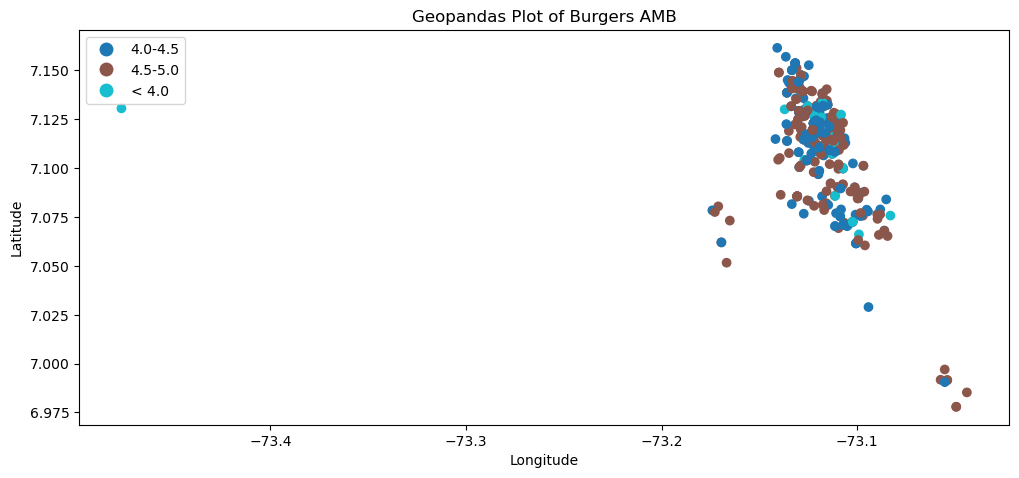

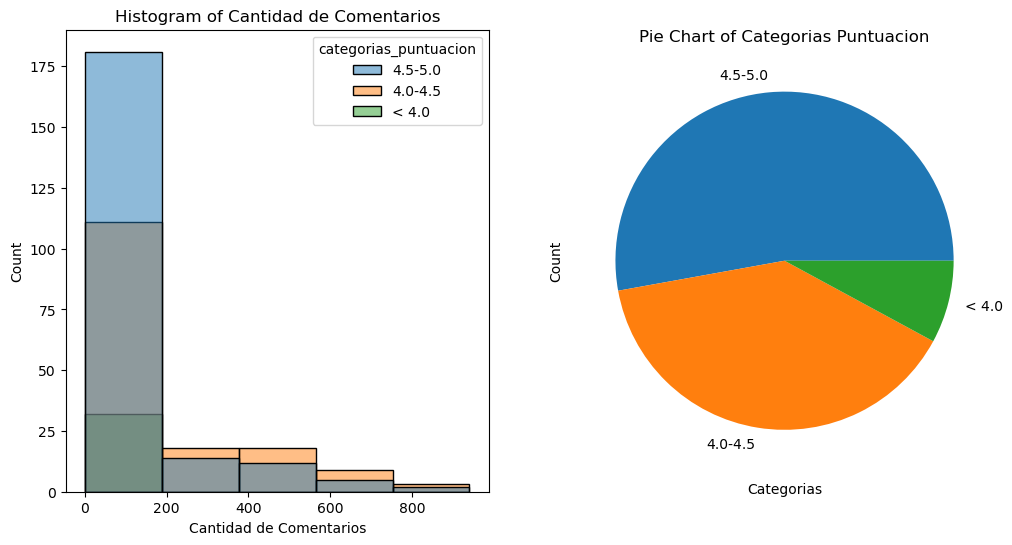

In [7]:
#Fix the previous charts so that the piechart is inside the geopandas plot:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
gdf.plot(ax=ax, column='categorias_puntuacion', legend=True, legend_kwds={'loc': 'upper left'})
ax.set_title('Geopandas Plot of Burgers AMB')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=burgers_AMB, x='cantidad_comentarios', ax=ax[0], bins=5, hue='categorias_puntuacion')
ax[0].set_xlabel('Cantidad de Comentarios')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of Cantidad de Comentarios')
burgers_AMB['categorias_puntuacion'].value_counts().plot(kind='pie', ax=ax[1])
ax[1].set_xlabel('Categorias')
ax[1].set_ylabel('Count')
ax[1].set_title('Pie Chart of Categorias Puntuacion')
plt.show()

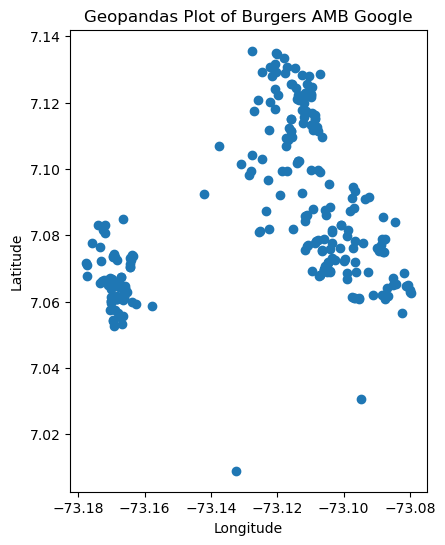

In [8]:
#Let's create a second geodataFrame, using resultados_finales/amb_googleMapsScrapper
burgers_AMB_google = pd.read_csv("resultados_finales/amb_googleMapsScrapper.csv")
burgers_AMB_google['geometry'] = gpd.points_from_xy(burgers_AMB_google['Longitude'], burgers_AMB_google['Latitude'])
gdf_google = gpd.GeoDataFrame(burgers_AMB_google, geometry='geometry')
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
gdf_google.plot(ax=ax, legend=True, legend_kwds={'loc': 'upper left'})
ax.set_title('Geopandas Plot of Burgers AMB Google')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()


In [9]:
#Let's visualize the 5 last rows
gdf_google.tail()

,name,Category,Rating,Nº Reviews,Stars,User Comment,Hours,Plus Code,Address,City,Province,Url,Latitude,Longitude,Url in Maps,geometry
252,Restaurante y Piqueteadero El Gran Porvenir,Restaurante de desayunos,"4,4",65.0,5.0,"un buen lugar para almorzar, variedad de comid...","domingo, 10 AMa6 PM; lunes, 10 AMa10 PM; marte...","3RCP+57 Girón, Santander","Cl. 35 #18-02, Girón, Santander","Girón, Santander",Santander,NaN,7.070484,-73.164325,https://maps.app.goo.gl/Us8bhohHpx8PeSFz6,POINT (-73.16433 7.07048)
253,Burgos Gastro House,Restaurante o cafetería,"4,8",39.0,5.0,"Excelente lugar, deliciosa la comida, y un amb...","domingo, 6a10:30 PM; lunes, 6a10:30 PM; martes...","3R6M+9F Girón, Santander","Calle 19d # 19 - 03 Portal campestre 2, Girón,...","Girón, Santander",Santander,NaN,7.060926,-73.166256,https://maps.app.goo.gl/eAmGrGkPsEhxMMvy8,POINT (-73.16626 7.06093)
254,típico Santafe 1952,Restaurante,"4,5",142.0,5.0,"Muy lindo el lugar, la comida muy rica, pero h...","domingo, 7:30 AMa3:30 PM; lunes, 7:30 AMa3:30 ...","3R8J+P2 Girón, Santander","Cra. 26 #29-07, Girón, Santander","Girón, Santander",Santander,NaN,7.066803,-73.169934,https://maps.app.goo.gl/HU74Br7NkSQwrMVTA,POINT (-73.16993 7.06680)
255,Comidas rapidas D&apos;Richard,Restaurante,"4,3",299.0,1.0,Hoy como en otras ocasiones almorcé en el rest...,"domingo, 10:30 AMa11:30 PM; lunes, 10:30 AMa11...","3VJG+PX Girón, Santander","Cl. 105a #15b- 58, Bucaramanga, Girón, Santander","Girón, Santander",Santander,NaN,7.081758,-73.122612,https://maps.app.goo.gl/7dmyN4VUWwWYLU6JA,POINT (-73.12261 7.08176)
256,RALLY Pizza&amp;Buger,Restaurante de comida rápida,"4,7",11.0,5.0,Todo super bueno sabor cacero y lo mejor que l...,"domingo, Abierto las 24 horas; lunes, Abierto ...","3VJF+9P Girón, Santander","Cra. 11a #105-22, Bucaramanga, Girón, Santander","Girón, Santander",Santander,http://www.instagram.com/rallypizzaburger/,7.080941,-73.125631,https://maps.app.goo.gl/eEE2sQWHCuCP47aw7,POINT (-73.12563 7.08094)


In [10]:
gdf_google['Rating'].unique()

array(['4,4', '4,6', '4,1', '4,5', '4,3', '4,8', '4,7', '4,0', '4,2',
       '3,4', '5,0', '3,8', '4,9', '3,5', '3,2', '3,9', '3,3', '3,6',
       '3,1', '2,8', '3,7', '1,0'], dtype=object)

In [11]:
#Let's create a column called 'categorias_puntuacion' based on the 'Rating' column:
#Replace the ',' for '.'in burgers_AMB_google['Rating']:
gdf_google['Rating'] =gdf_google['Rating'].str.replace(',', '.')
#Turn burgers_AMB_google['Rating'] into a float type:
gdf_google['Rating'] = gdf_google['Rating'].astype(float)
gdf_google['categorias_puntuacion'] = gdf_google['Rating'].apply(get_score_range)

In [12]:
gdf_google.columns

Index(['name', 'Category', 'Rating', 'Nº Reviews', 'Stars', 'User Comment',
       'Hours', 'Plus Code', 'Address', 'City', 'Province', 'Url', 'Latitude',
       'Longitude', 'Url in Maps', 'geometry', 'categorias_puntuacion'],
      dtype='object')

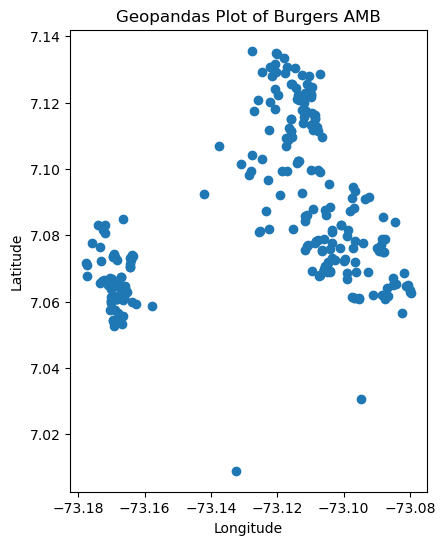

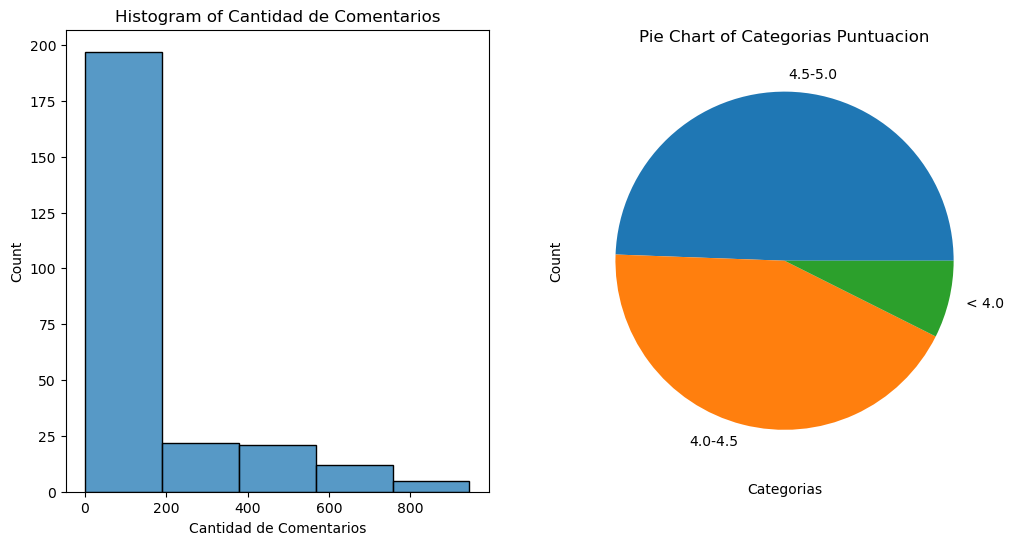

In [13]:
#Fix the previous charts so that the piechart is inside the geopandas plot:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
gdf_google.plot(ax=ax)
ax.set_title('Geopandas Plot of Burgers AMB')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=gdf_google, x='Nº Reviews', ax=ax[0], bins=5)
ax[0].set_xlabel('Cantidad de Comentarios')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of Cantidad de Comentarios')
gdf_google['categorias_puntuacion'].value_counts().plot(kind='pie', ax=ax[1])
ax[1].set_xlabel('Categorias')
ax[1].set_ylabel('Count')
ax[1].set_title('Pie Chart of Categorias Puntuacion')
plt.show()